Exploratory data analysis

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta
import time
import warnings

from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from xgboost import XGBRegressor

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# set options
pd.set_option('display.float_format', '{:.2f}'.format)

# import data
df_train = pd.read_csv("./kaggle/input/store-sales-time-series-forecasting/train.csv", index_col="id")
df_test = pd.read_csv("./kaggle/input/store-sales-time-series-forecasting/test.csv", index_col="id")
df_holidays = pd.read_csv("./kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
df_oil = pd.read_csv("./kaggle/input/store-sales-time-series-forecasting/oil.csv")
df_stores = pd.read_csv("./kaggle/input/store-sales-time-series-forecasting/stores.csv")
df_transactions = pd.read_csv("./kaggle/input/store-sales-time-series-forecasting/transactions.csv")

In [2]:
#pip install --upgrade --force-reinstall xgboost

In [3]:
print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

# set date column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# print date intervals for train and test set
print("Length of the train set:", df_train['date'].dt.date.min(), "-", df_train['date'].dt.date.max())
print("Length of the test set:", df_test['date'].dt.date.min(), "-", df_test['date'].dt.date.max())

Training set shape: (3000888, 5)
Test set shape: (28512, 4)
Length of the train set: 2013-01-01 - 2017-08-15
Length of the test set: 2017-08-16 - 2017-08-31


In [4]:
def add_additional_tables(
        df:pd.DataFrame, 
        df_oil:pd.DataFrame,
        df_stores:pd.DataFrame,
        df_holidays:pd.DataFrame,
        df_transactions:pd.DataFrame
    ) -> pd.DataFrame:
    """
    Adds columns included in additional tables to the base dataframe (df)

    Args:
    - df (pd.DataFrame): dataframe to which additional columns will be added.
    - df_oil (pd.DataFrame): oil price data.
    - df_stores (pd.DataFrame): additional information about the stores.
    - df_holidays: information about holidays.
    - df_transactions: data about transactions per store and day.
    """

    # reset index to restore it at the end (important when treatment is applied to test data)
    df = df.reset_index()
    
    # merge with oil table
    df_oil['date'] = pd.to_datetime(df_oil['date'])

    df = df.merge(df_oil, on='date', how='left')

    # merge with stores table
    df_stores.rename(columns={'type': 'store_type'}, inplace=True)
    df = df.merge(df_stores, on='store_nbr', how='left')

    # merge with transactions table
    df_transactions['date'] = pd.to_datetime(df_transactions['date'])
    df = df.merge(df_transactions, on=['date', 'store_nbr'], how='left')
    
    # merge with holidays_events table

    # drop duplicated holidays
    df_holidays = df_holidays.loc[~((df_holidays['date'] == '2012-12-24') &(df_holidays['type'] == 'Additional'))]
    df_holidays = df_holidays.loc[~((df_holidays['date'] == '2012-12-31') &(df_holidays['type'] == 'Additional'))]
    df_holidays = df_holidays.loc[~((df_holidays['date'] == '2014-12-26') &(df_holidays['type'] == 'Additional'))]
    df_holidays = df_holidays.loc[~((df_holidays['date'] == '2016-07-24') &(df_holidays['type'] == 'Additional'))]
    df_holidays = df_holidays.loc[~(df_holidays['description'].str.contains("Terremoto Manabi"))] 

    # divide table by region
    df_holidays['date'] = pd.to_datetime(df_holidays['date'])
    df_holidays_national = df_holidays.loc[df_holidays['locale'] == 'National'].drop(columns=['locale_name'])
    df_holidays_regional = df_holidays.loc[df_holidays['locale'] == 'Regional'].rename(columns={'locale_name': 'state'})
    df_holidays_local = df_holidays.loc[df_holidays['locale'] == 'Local'].rename(columns={'locale_name': 'city'})

    # merge national holidays
    df = df.merge(df_holidays_national, on='date', how='left')

    # merge regional holidays
    df = df.merge(df_holidays_regional, on=['date', 'state'], how='left', suffixes=('', '_reg'))

    # merge local holidays
    df = df.merge(df_holidays_local, on=['date', 'city'], how='left', suffixes=('', '_loc'))

    # now coalesce duplicated columns
    for col in ['type', 'locale', 'description', 'transferred']:  # the overlapping holiday columns
        for suffix in ['_reg', '_loc']:
            if col + suffix in df.columns:
                df[col] = df[col].combine_first(df[col + suffix])
                df.drop(columns=[col + suffix], inplace=True)

    # restore original index
    df = df.set_index('id').sort_index()
    
    return df

df_train = add_additional_tables(df_train, df_oil, df_stores, df_holidays, df_transactions)

In [5]:
df_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 15 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date          3000888 non-null  datetime64[ns]
 1   store_nbr     3000888 non-null  int64         
 2   family        3000888 non-null  object        
 3   sales         3000888 non-null  float64       
 4   onpromotion   3000888 non-null  int64         
 5   dcoilwtico    2072466 non-null  float64       
 6   city          3000888 non-null  object        
 7   state         3000888 non-null  object        
 8   store_type    3000888 non-null  object        
 9   cluster       3000888 non-null  int64         
 10  transactions  2755104 non-null  float64       
 11  type          217767 non-null   object        
 12  locale        217767 non-null   object        
 13  description   217767 non-null   object        
 14  transferred   217767 non-null   object        
dtypes: 

Dependent variable

count   3000888.00
mean        357.78
std        1102.00
min           0.00
25%           0.00
50%          11.00
75%         195.85
max      124717.00
Name: sales, dtype: float64


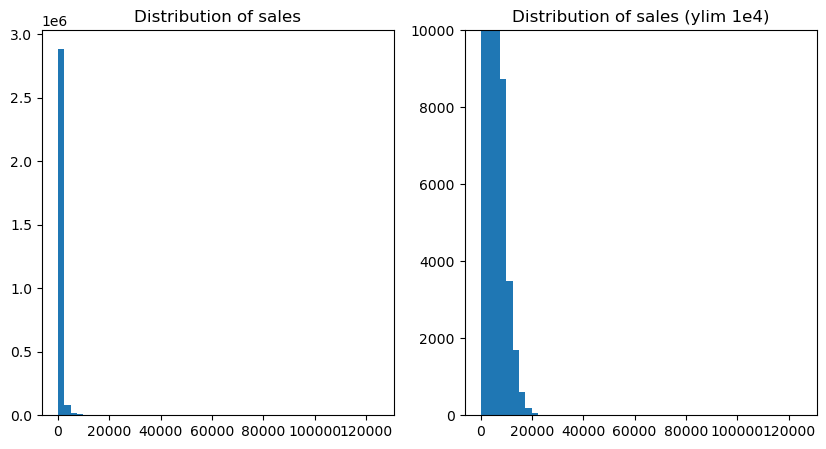

In [6]:
print(df_train['sales'].describe())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First plot: no ylim
axes[0].hist(df_train['sales'], bins=50)
axes[0].set_title('Distribution of sales')

# Second plot: with ylim
axes[1].hist(df_train['sales'], bins=50)
axes[1].set_ylim(0, 1e4)
axes[1].set_title('Distribution of sales (ylim 1e4)')

plt.show()

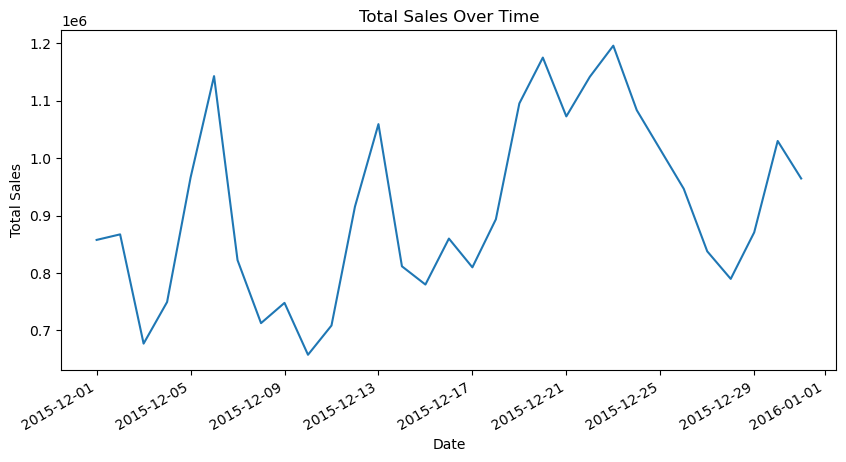

Dates with sales < 1e5: 

              date  total_date
id                            
0       2013-01-01     2511.62
648648  2014-01-01     8602.07
1297296 2015-01-01    12773.62
1945944 2016-01-01    16433.39
2596374 2017-01-01    12082.50


In [7]:
df_train.loc[(df_train['date'] <= '12/31/2015') & (df_train['date']  >='12/01/2015')].groupby('date')['sales'].sum().plot(figsize=(10, 5))
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# dates with less than 10000 sales (units)
df_train['total_date'] = df_train.groupby('date')['sales'].transform('sum')
print("Dates with sales < 1e5: \n")
print(df_train.loc[df_train['total_date'] < 1e5, ['date', 'total_date']].drop_duplicates().head())
df_train.drop(columns=['total_date'], axis=1, inplace=True)

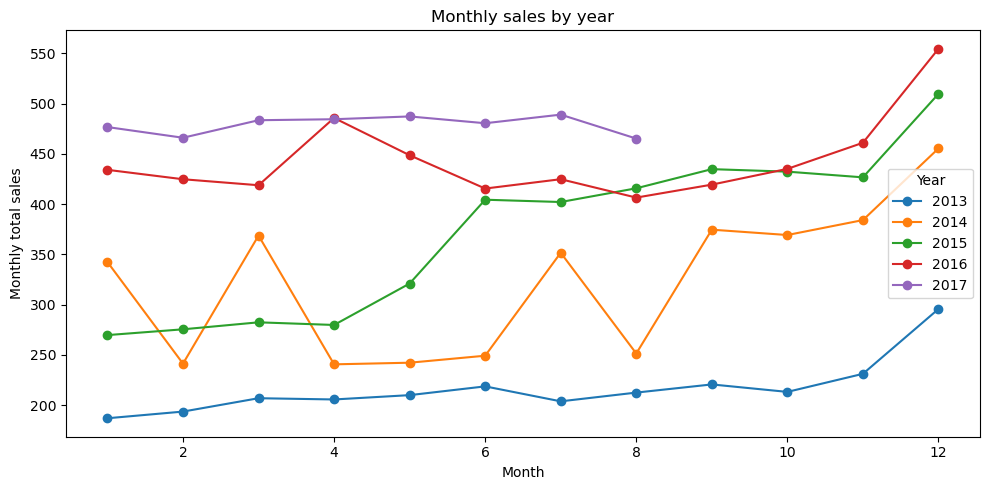

In [8]:
# monthly totals (sum of daily sales per month)
monthly_totals = df_train.set_index('date').resample('ME')['sales'].mean()

# build pivot: rows = month (Jan..Dec), columns = year
monthly = monthly_totals.to_frame(name='sales')
monthly['year'] = monthly.index.year
monthly['month'] = monthly.index.month
monthly_pivot = monthly.pivot_table(index='month', columns='year', values='sales')

# plot
ax = monthly_pivot.plot(figsize=(10, 5), marker='o')
ax.set_title('Monthly sales by year')
ax.set_xlabel('Month')
ax.set_ylabel('Monthly total sales')
ax.legend(title='Year', loc='best')
plt.tight_layout()
plt.show()

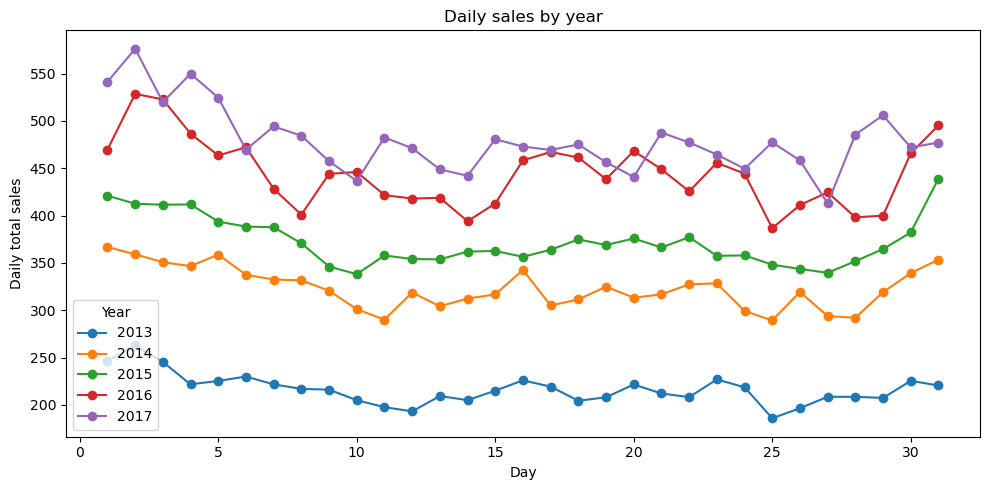

In [9]:
# daily totals (sum of daily sales)
daily_totals = df_train.set_index('date').resample('D')['sales'].mean()

# build pivot: rows = day (1,...,31), columns = year
daily = daily_totals.to_frame(name='sales')
daily['year'] = daily.index.year
daily['day'] = daily.index.day
daily_pivot = daily.pivot_table(index='day', columns='year', values='sales')

# plot
ax = daily_pivot.plot(figsize=(10, 5), marker='o')
ax.set_title('Daily sales by year')
ax.set_xlabel('Day')
ax.set_ylabel('Daily total sales')
ax.legend(title='Year', loc='best')
plt.tight_layout()
plt.show()

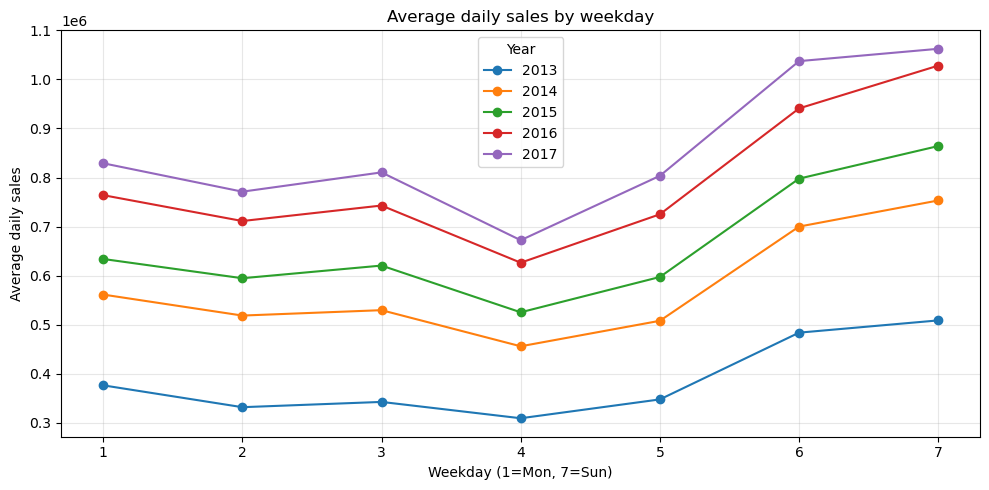

In [10]:
# daily totals, then average by weekday per year
daily = df_train.groupby('date')['sales'].sum().reset_index()
daily['year'] = daily['date'].dt.year
daily['weekday'] = daily['date'].dt.weekday + 1

weekday_pivot = daily.groupby(['weekday', 'year'])['sales'].mean().unstack('year')

# simple line plot: one line per year, x = weekday 1..7
ax = weekday_pivot.plot(marker='o', figsize=(10, 5))
ax.set_xticks(range(1, 8))
ax.set_xlabel('Weekday (1=Mon, 7=Sun)')
ax.set_ylabel('Average daily sales')
ax.set_title('Average daily sales by weekday')
ax.legend(title='Year', loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Independent variables

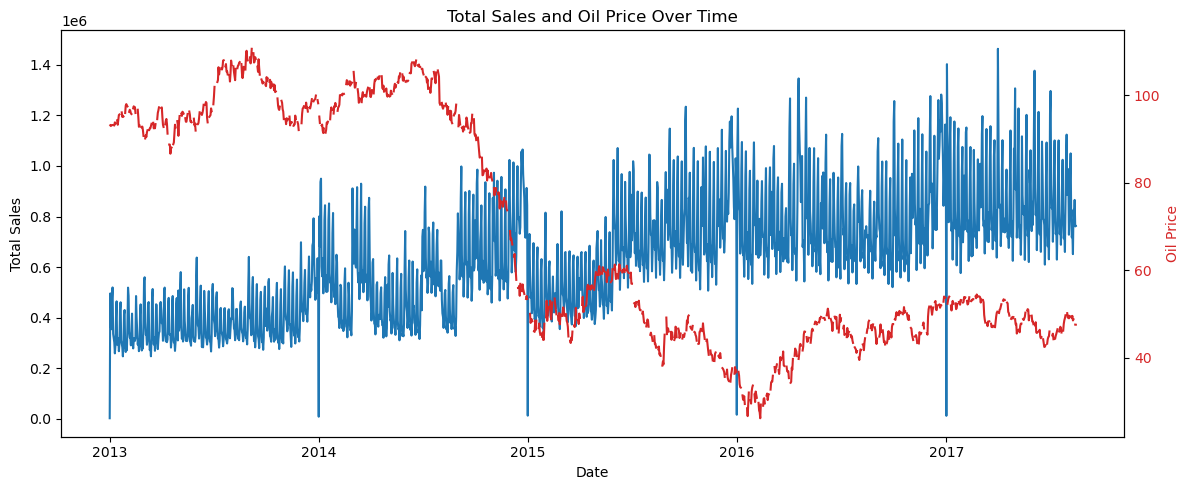

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot total sales
sales_by_date = df_train.groupby('date')['sales'].sum()
ax1.plot(sales_by_date.index, sales_by_date.values, label='Total Sales')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales')
ax1.tick_params(axis='y')
ax1.set_title('Total Sales and Oil Price Over Time')

# Plot oil price on the right axis
ax2 = ax1.twinx()
oil_by_date = df_train.set_index('date')['dcoilwtico']
ax2.plot(oil_by_date.index, oil_by_date.values, color='tab:red', label='Oil Price')
ax2.set_ylabel('Oil Price', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

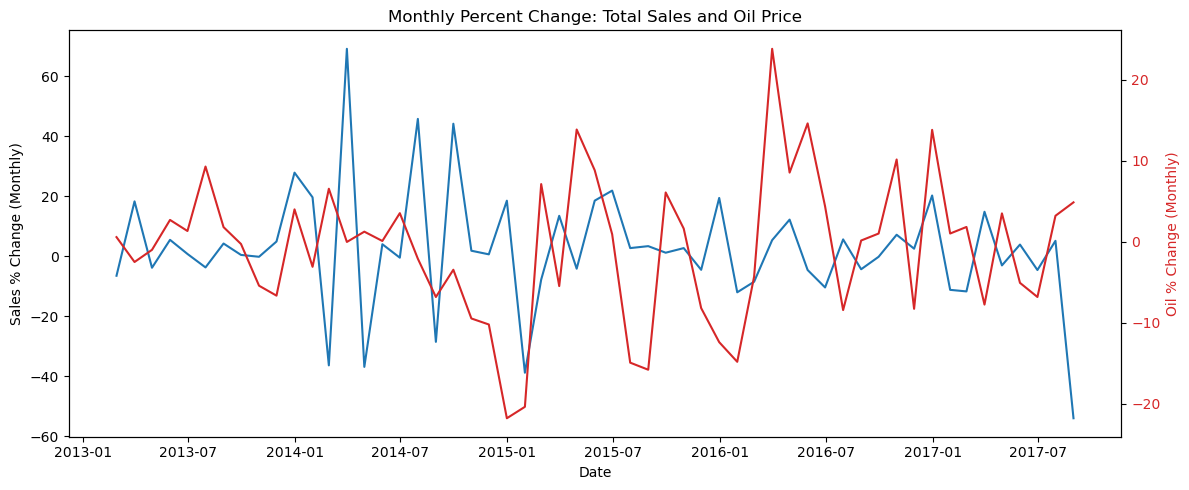

Correlation coetaneous oil price change:  0.0028279105407534384
Correlation one-month lagged oil price change:  0.17804350914815853


In [12]:
# Resample sales by month and calculate percent change
sales_by_month = df_train.groupby('date')['sales'].sum().resample('ME').sum()
sales_pct_change_month = sales_by_month.pct_change() * 100

# Resample oil price by month and calculate percent change
oil_by_month = df_train.set_index('date')['dcoilwtico'].resample('ME').mean()
oil_pct_change_month = oil_by_month.pct_change() * 100

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot monthly sales percent change
ax1.plot(sales_pct_change_month.index, sales_pct_change_month.values, color='tab:blue', label='Sales % Change')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales % Change (Monthly)')
ax1.tick_params(axis='y')
ax1.set_title('Monthly Percent Change: Total Sales and Oil Price')

# Plot monthly oil price percent change
ax2 = ax1.twinx()
ax2.plot(oil_pct_change_month.index, oil_pct_change_month.values, color='tab:red', label='Oil % Change')
ax2.set_ylabel('Oil % Change (Monthly)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

print("Correlation coetaneous oil price change: ", sales_pct_change_month.corr(oil_pct_change_month.shift(0)))
print("Correlation one-month lagged oil price change: ", sales_pct_change_month.corr(oil_pct_change_month.shift(1)))

C:\Users\bandi\anaconda\Lib\site-packages\numpy\lib\_function_base_impl.py:2882: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


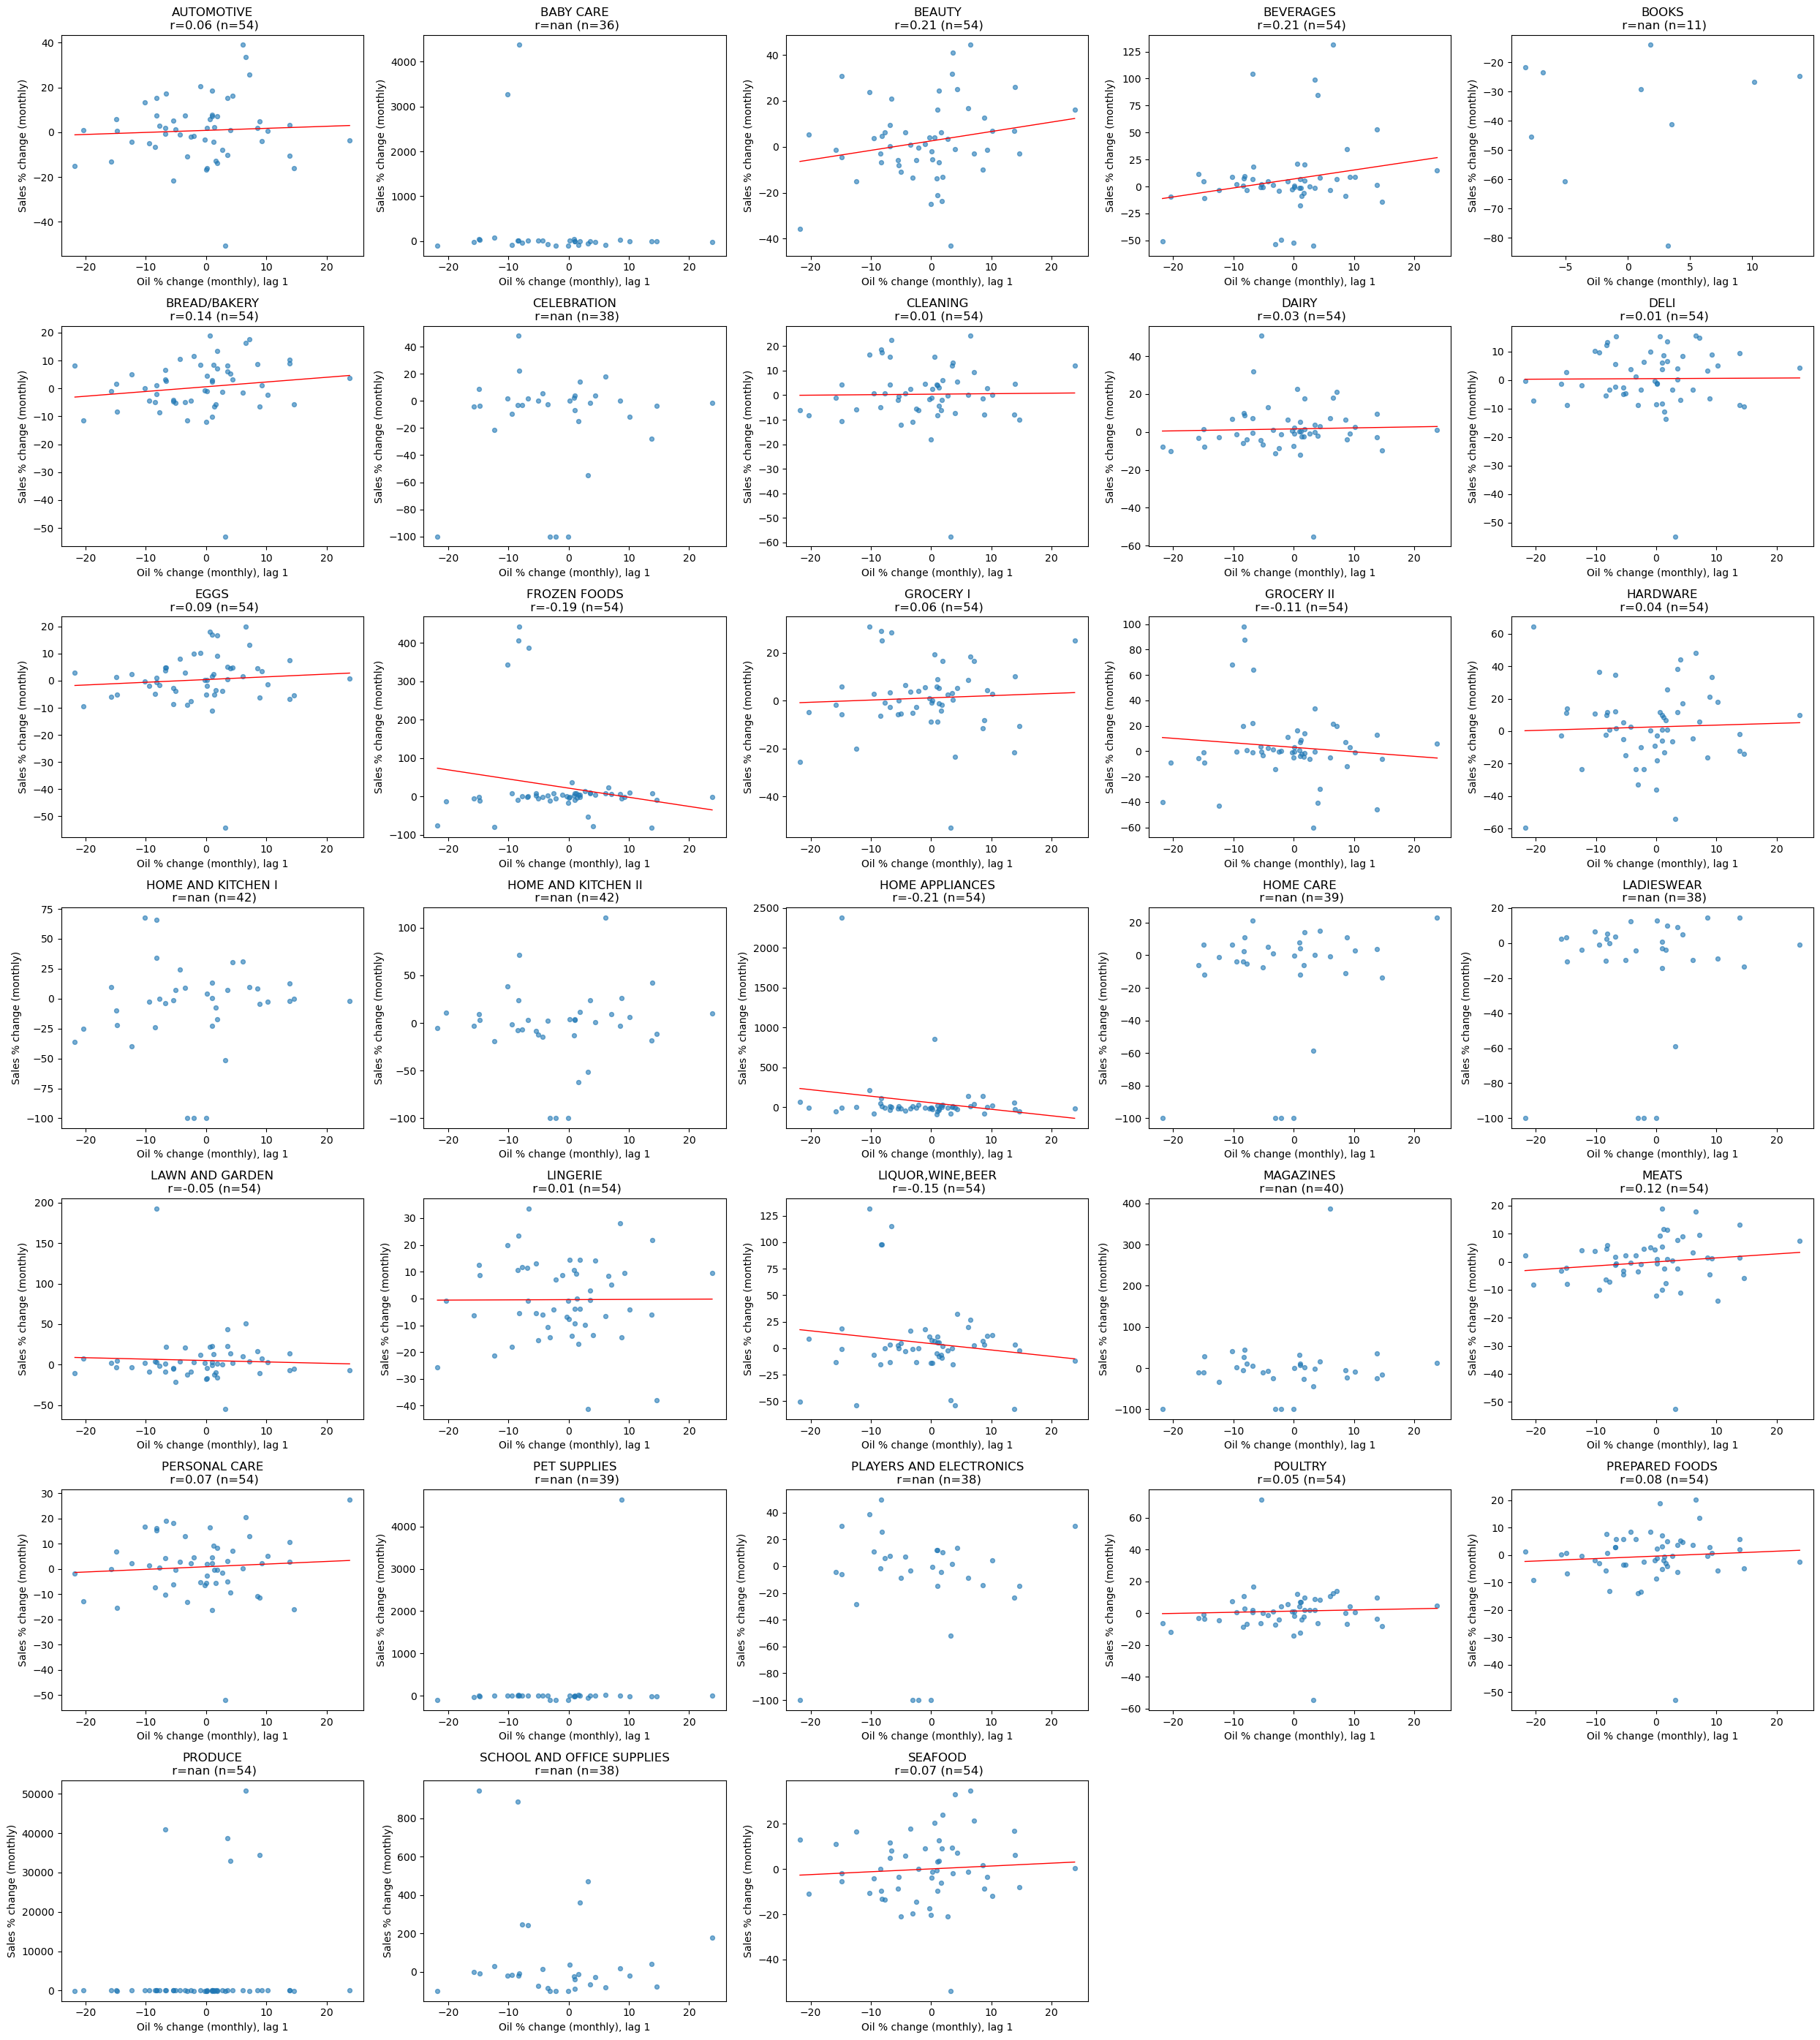

In [13]:
# monthly totals per family and monthly oil mean
sales_by_family = df_train.groupby(['date','family'])['sales'].sum().unstack('family').sort_index()
sales_m = sales_by_family.resample('ME').sum()
sales_pct = sales_m.pct_change() * 100

# Resample oil price by month and calculate percent change
oil_by_month = df_train.set_index('date')['dcoilwtico'].resample('ME').mean()
oil_pct_change_month = oil_by_month.pct_change() * 100
oil_pct_lag1 = oil_pct_change_month.shift(1)  # oil previous month -> sales current month

families = sales_pct.columns.tolist()
n = len(families)
cols = 5
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

for i, fam in enumerate(families):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    s = sales_pct[fam]
    # align with lagged oil and drop NA
    s_al, o_al = s.align(oil_pct_lag1, join='inner')
    mask = s_al.notna() & o_al.notna()
    x = o_al[mask]
    y = s_al[mask]

    if len(x) < 3:
        ax.text(0.5, 0.5, 'Not enough data', ha='center', va='center')
    else:
        ax.scatter(x, y, alpha=0.6, s=18)
        # regression line
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 50)
        ax.plot(xs, m * xs + b, color='red', linewidth=1)
    corr = y.corr(x) if len(x) >= 2 else np.nan
    ax.set_title(f"{fam}\n r={corr:.2f} (n={len(x)})")
    ax.set_xlabel('Oil % change (monthly), lag 1')
    ax.set_ylabel('Sales % change (monthly)')

# hide any empty subplots
for j in range(i+1, rows * cols):
    axes[j // cols][j % cols].axis('off')

plt.tight_layout()
plt.show()

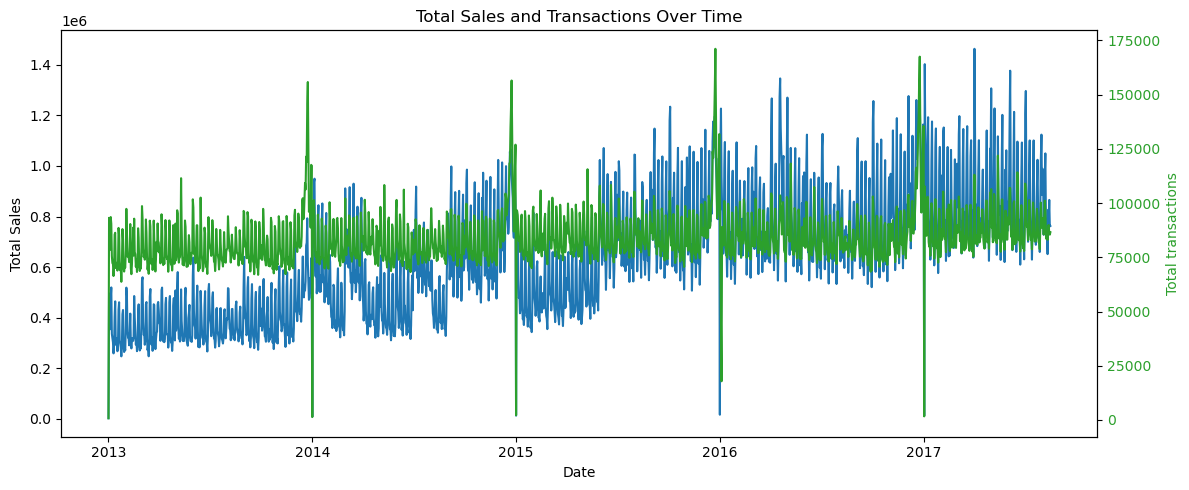

Correlation between sales and transactions:  0.6765087007296068


In [14]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot total sales
sales_by_date = df_train.groupby('date')['sales'].sum()
ax1.plot(sales_by_date.index, sales_by_date.values, label='Total Sales')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales')
ax1.tick_params(axis='y')
ax1.set_title('Total Sales and Transactions Over Time')

# Plot total transactions
ax2 = ax1.twinx()
transactions_by_date = df_transactions.groupby('date')['transactions'].sum()
ax2.plot(transactions_by_date.index, transactions_by_date.values, color='tab:green', label='Total transactions')
ax2.set_ylabel('Total transactions', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()
plt.show()

print("Correlation between sales and transactions: ", sales_by_date.corr(transactions_by_date.shift(0)))

In [15]:
df_train.loc[(df_train['transactions'].isna()) & (df_train['sales'] == 0)].shape[0]/df_train.loc[(df_train['transactions'].isna())].shape[0]

0.9867851446798815

In [16]:
df_transactions.date.max()

Timestamp('2017-08-15 00:00:00')

Product families with high sales during Christmas: 


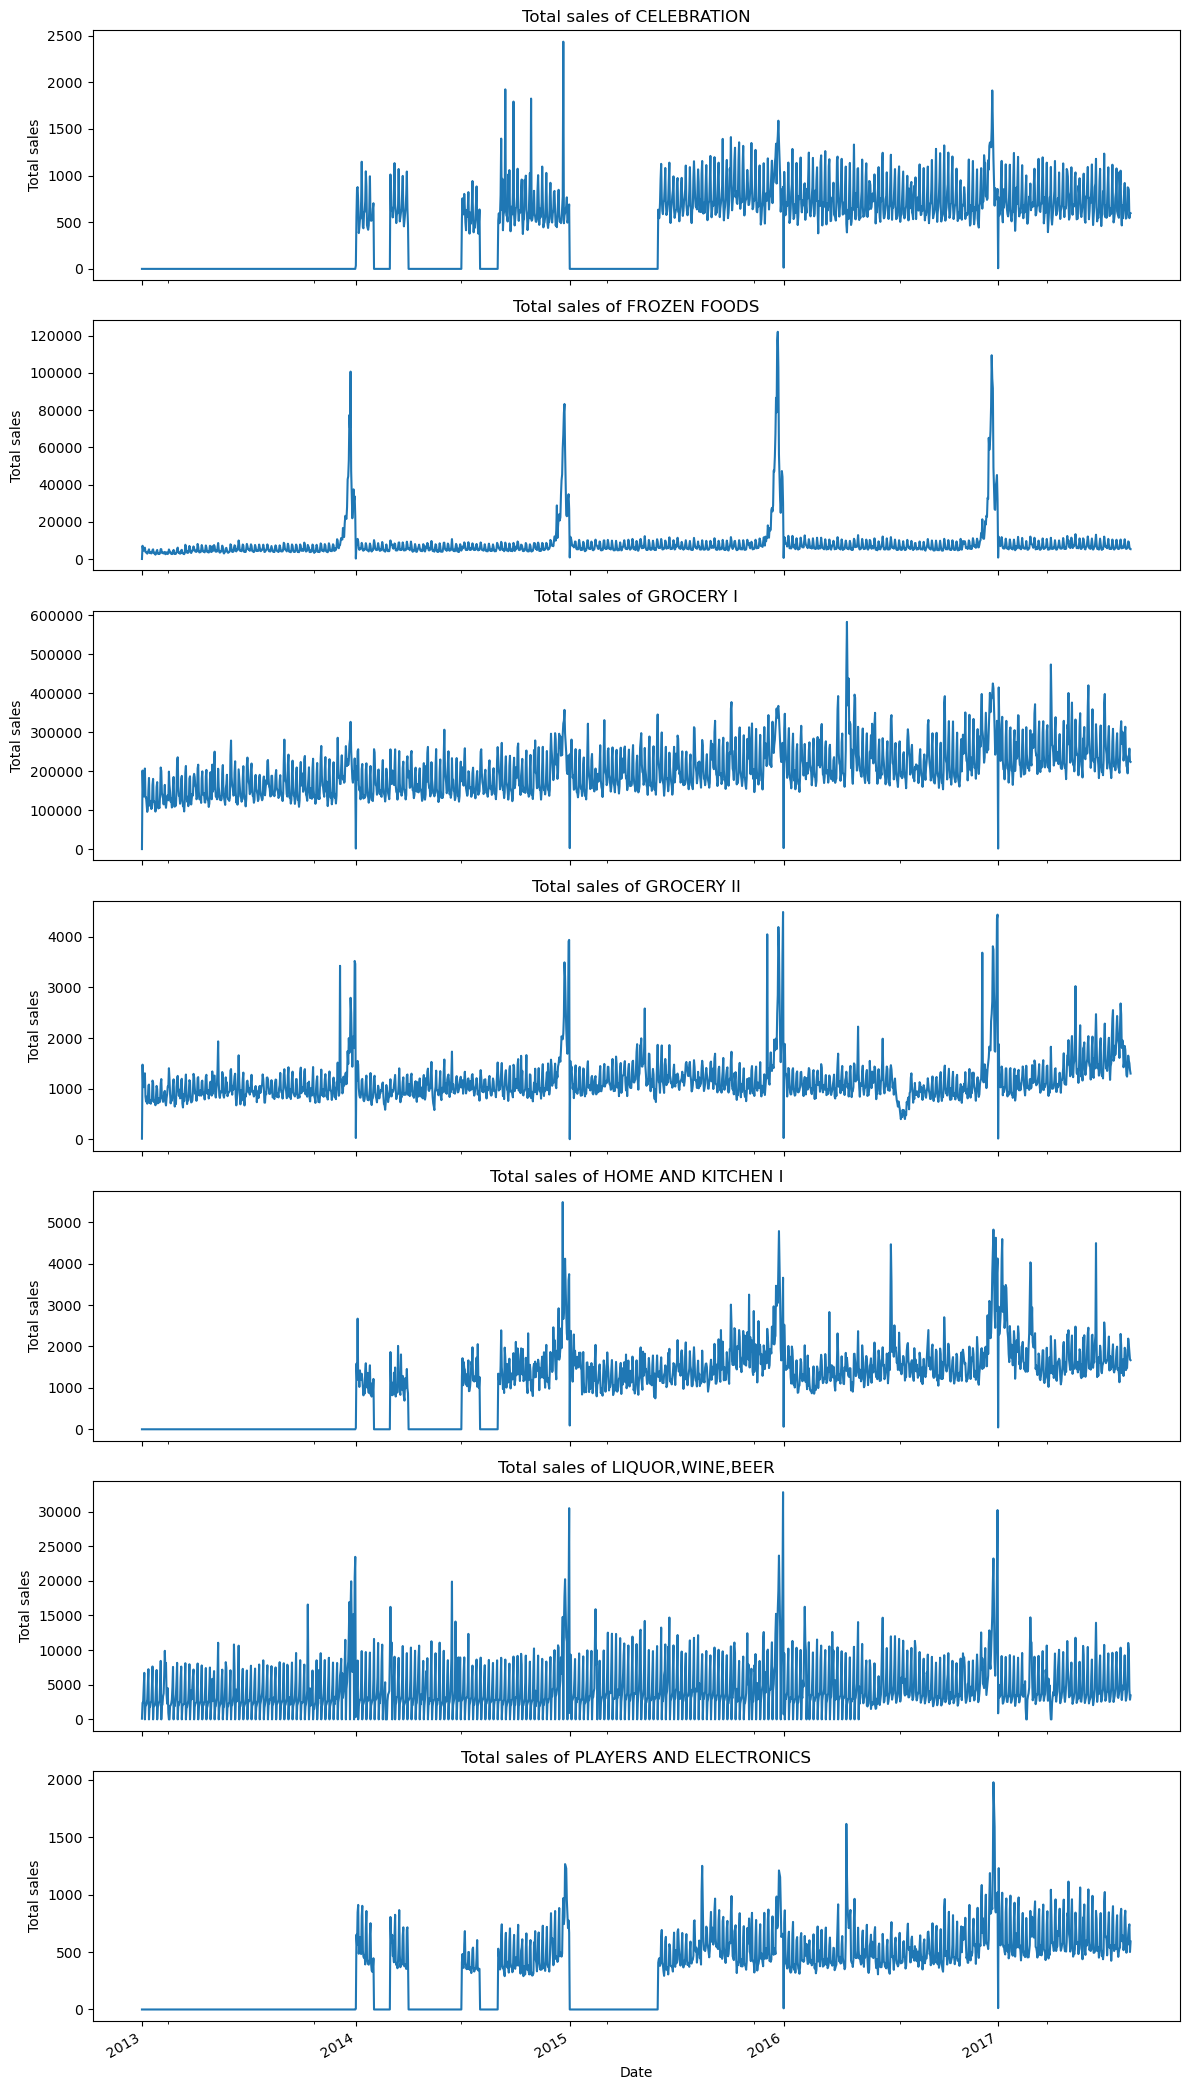

Product families with high sales before beginning of academic year (August and September): 


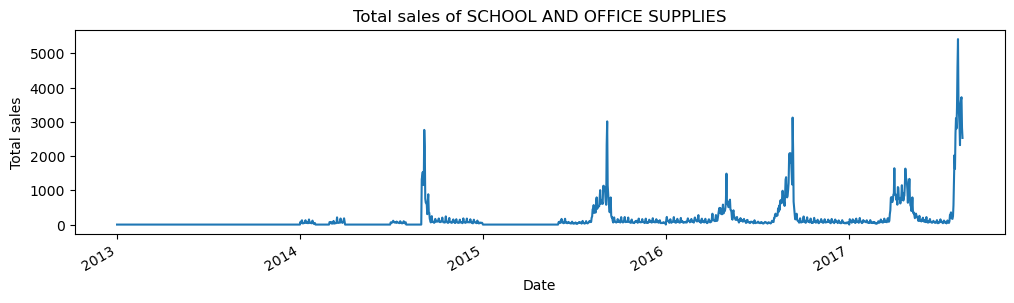

In [17]:
print("Product families with high sales during Christmas: ")
cat_1 = ['CELEBRATION', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I', 'LIQUOR,WINE,BEER', 'PLAYERS AND ELECTRONICS']
sales_by_family = df_train.groupby(['date', 'family'])['sales'].sum().unstack('family')
fig, axes = plt.subplots(len(cat_1), 1, figsize=(12, 3 * len(cat_1)), sharex=True)
for i, fam in enumerate(cat_1):
    sales_by_family[fam].plot(ax=axes[i], legend=False)
    axes[i].set_title(f'Total sales of {fam}')
    axes[i].set_ylabel('Total sales')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

print("Product families with high sales before beginning of academic year (August and September): ")
sales_by_family['SCHOOL AND OFFICE SUPPLIES'].plot(figsize=(12, 3))
plt.title('Total sales of SCHOOL AND OFFICE SUPPLIES')
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.show()

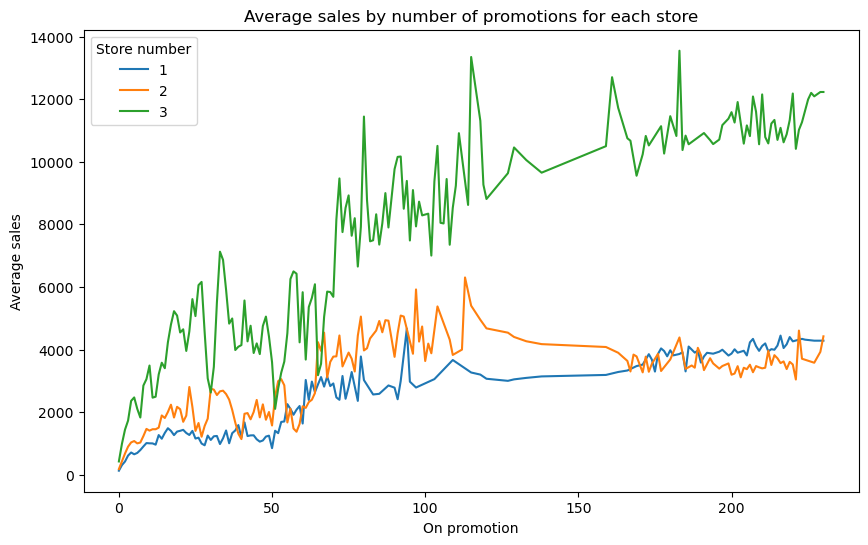

In [18]:
df_plot = df_train.loc[
        (df_train['store_nbr'].isin([1, 2, 3])) &
        (df_train['date'].dt.month != 12) &
        ~((df_train['date'].dt.month.isin([4, 5])) & (df_train['date'].dt.year == 2016))
    ].groupby(['onpromotion', 'store_nbr'])['sales'].mean().unstack('store_nbr')

df_plot = df_plot.interpolate()  # Interpolate missing values

df_plot.plot(figsize=(10, 6))
plt.title('Average sales by number of promotions for each store')
plt.xlabel('On promotion')
plt.ylabel('Average sales')
plt.legend(title='Store number')
plt.show()

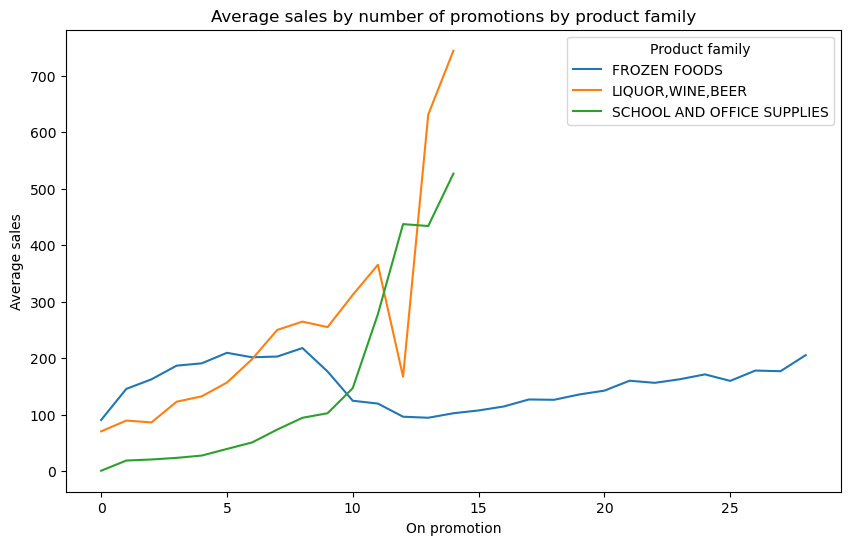

In [19]:
df_plot = df_train.loc[
        (df_train['family'].isin(['SCHOOL AND OFFICE SUPPLIES', 'LIQUOR,WINE,BEER', 'FROZEN FOODS'])) & 
        (df_train['date'].dt.month != 12) &
        ~((df_train['date'].dt.month.isin([4, 5])) & (df_train['date'].dt.year == 2016))
    ].groupby(['onpromotion', 'family'])['sales'].mean().unstack('family')

#df_plot = df_plot.interpolate()  # Interpolate missing values

df_plot.plot(figsize=(10, 6))
plt.title('Average sales by number of promotions by product family')
plt.xlabel('On promotion')
plt.ylabel('Average sales')
plt.legend(title='Product family')
plt.show()

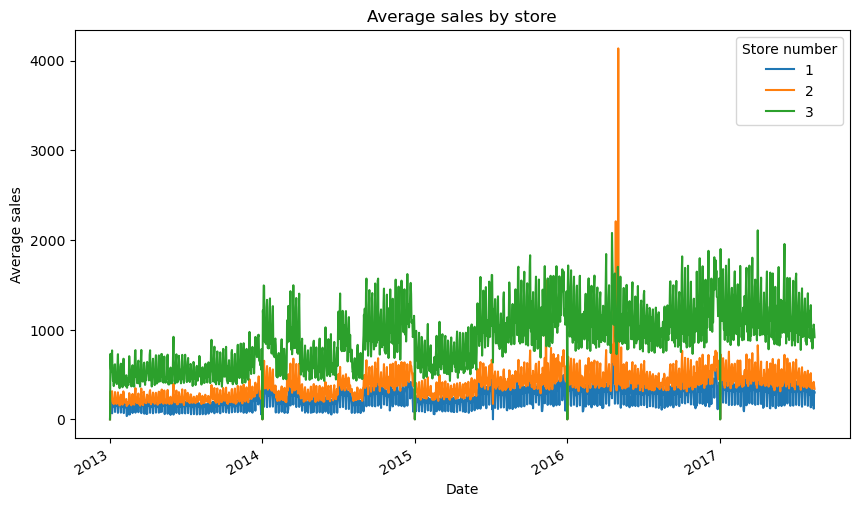

In [20]:
df_plot = df_train.loc[
        (df_train['store_nbr'].isin([1, 2, 3]))
    ].groupby(['date', 'store_nbr'])['sales'].mean().unstack('store_nbr')

df_plot.plot(figsize=(10, 6))
plt.title('Average sales by store')
plt.xlabel('Date')
plt.ylabel('Average sales')
plt.legend(title='Store number')
plt.show()

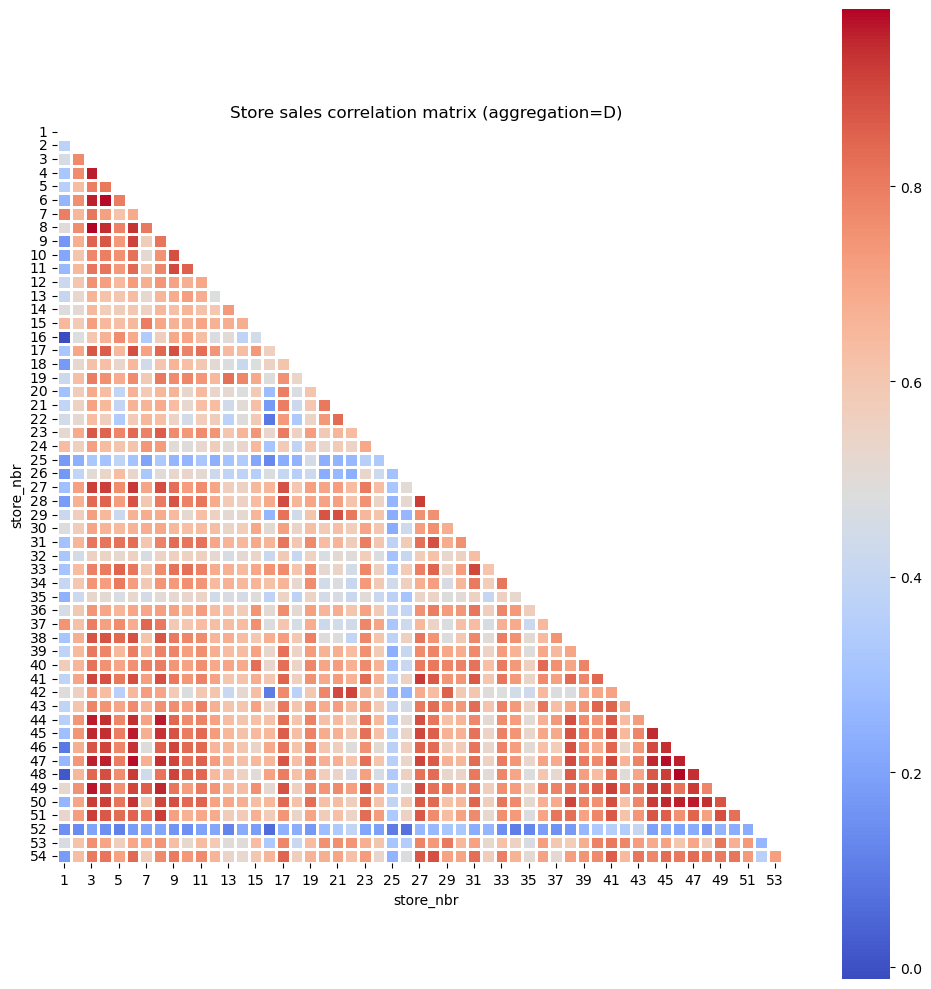

In [21]:
# choose aggregation: 'M' = monthly sales, 'D' = daily sales
agg = 'D'

# pivot: rows = period, cols = store_nbr, values = total sales in period (w/o disaggregating by family type)
store_ts = (
    df_train
    .set_index('date')
    .groupby('store_nbr')['sales']
    .resample(agg)
    .sum()
    .unstack(level="store_nbr")
)

# compute correlation matrix between stores
corr = store_ts.corr()

# plot heatmap
plt.figure(figsize=(10, 10))
mask = np.triu(corr)
sns.heatmap(corr,
        annot=False,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=True)
plt.title(f"Store sales correlation matrix (aggregation={agg})")
plt.xlabel('store_nbr')
plt.ylabel('store_nbr')
plt.tight_layout()
plt.show()

In [22]:
first_sale = df_train.loc[df_train['sales'] > 0].groupby('store_nbr')['date'].min()
print(first_sale[first_sale > '2013-01-02']) # on 2013-01-01 no sales where recorded due to New Year's day

store_nbr
20   2015-02-13
21   2015-07-24
22   2015-10-09
29   2015-03-20
36   2013-05-09
42   2015-08-21
52   2017-04-20
53   2014-05-29
Name: date, dtype: datetime64[ns]


In [23]:
sales_by_family = df_train.groupby(['store_nbr', 'family'])['sales'].sum()
print(sales_by_family[sales_by_family == 0].shape[0], "combinations store_nbr X family with 0 total sales.")

53 combinations store_nbr X family with 0 total sales.


store_nbr  family                    
2          BOOKS                        239.00
5          BOOKS                        230.00
6          BOOKS                         76.00
           SCHOOL AND OFFICE SUPPLIES   446.00
10         BABY CARE                    461.00
           LAWN AND GARDEN               26.00
12         LAWN AND GARDEN               16.00
13         LAWN AND GARDEN               21.00
14         BABY CARE                     11.00
15         LAWN AND GARDEN               15.00
Name: sales, dtype: float64


Text(0.5, 1.0, 'STORE 10 - LAWN AND GARDEN')

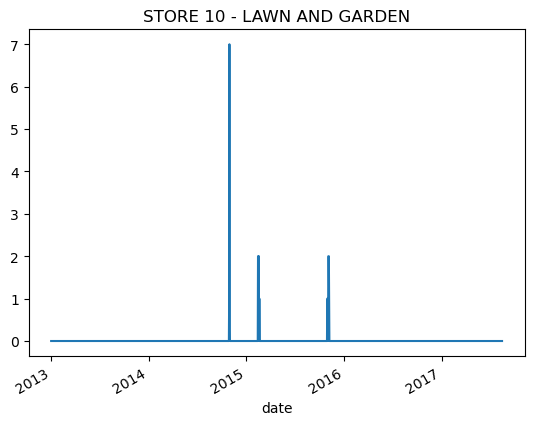

In [24]:
sales_last_90 = (
    df_train.loc[df_train['date'] > (max(df_train['date']) - timedelta(days=90))]
    .groupby(['store_nbr', 'family'])['sales']
    .sum()
    .reset_index(name='sales_last_90')
)
df_train = df_train.reset_index()
df_train = df_train.merge(sales_last_90, on=['store_nbr', 'family'], how='left').set_index('id')
df_train['sales_last_90'] = df_train['sales_last_90'].fillna(0)

sales_innactive = df_train.loc[df_train['sales_last_90'] == 0].groupby(['store_nbr', 'family'])['sales'].sum()
print(sales_innactive.loc[sales_innactive > 0][0:10])
df_train.drop('sales_last_90', inplace=True, axis=1)

df_train[(df_train.store_nbr == 10) & (df_train.family == "LAWN AND GARDEN")].set_index("date").sales.plot()
plt.title("STORE 10 - LAWN AND GARDEN")

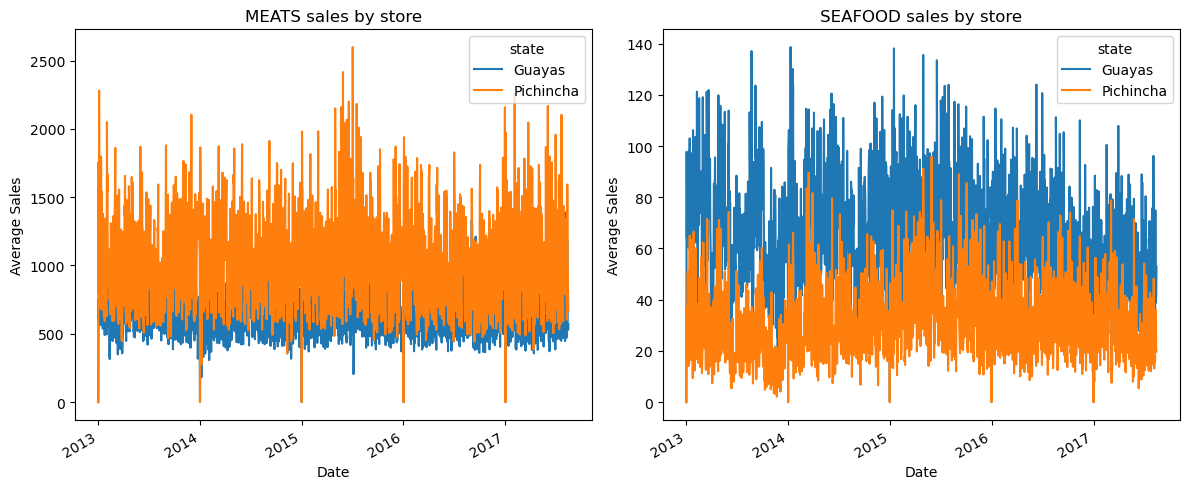

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MEATS sales
meats_sales = df_train.loc[
        (df_train['store_nbr'].isin([48, 51])) & (df_train['family'] == 'MEATS')
    ].groupby(['date', 'state'])['sales'].mean().unstack('state')
meats_sales.plot(ax=axes[0])
axes[0].set_title('MEATS sales by store')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Average Sales')

# SEAFOOD sales
seafood_sales = df_train.loc[
        (df_train['store_nbr'].isin([48, 51])) & (df_train['family'] == 'SEAFOOD')
    ].groupby(['date', 'state'])['sales'].mean().unstack('state')
seafood_sales.plot(ax=axes[1])
axes[1].set_title('SEAFOOD sales by store')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Sales')

plt.tight_layout()
plt.show()

In [26]:
# fill missing values for regular (no holidays) days
df_train['type'] = df_train['type'].fillna('Regular day')
df_train['transferred'] = df_train['transferred'].fillna('N/A')

df_train.groupby(['type', 'transferred'])['sales'].mean()

type         transferred
Additional   False         521.62
Bridge       False         446.75
Event        False         339.80
Holiday      False         349.59
             True          283.25
Regular day  N/A           354.77
Transfer     False         470.43
Work Day     False         372.16
Name: sales, dtype: float64

Time series decomposition

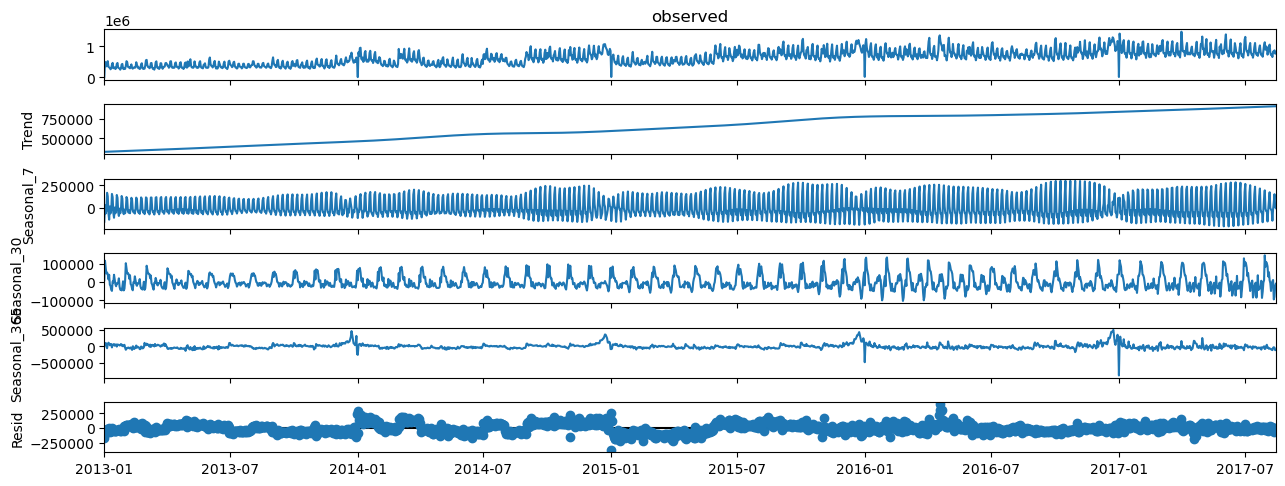

In [27]:
# aggregate sales by date
ts = df_train.groupby('date')['sales'].sum()

# perform seasonal decomposition
result = MSTL(ts, periods=(7, 30, 365)).fit()

fig = result.plot()
fig.set_size_inches(15, 5)
plt.show()

Autocorrelation

C:\Users\bandi\AppData\Local\Temp\ipykernel_15892\2879966243.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


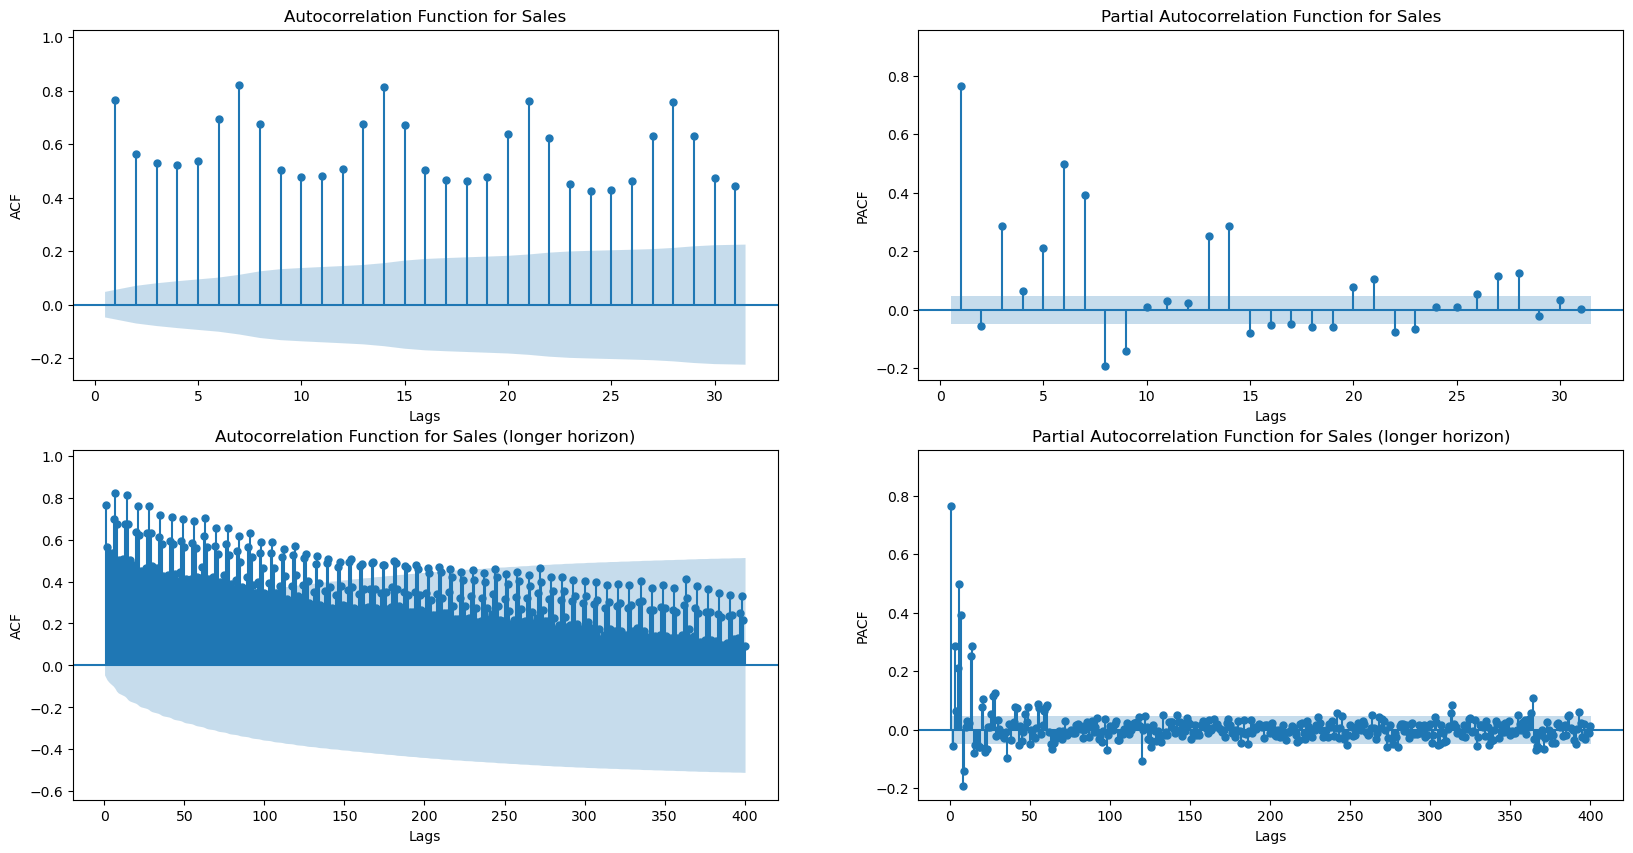

In [28]:
total_sales = df_train.groupby('date')['sales'].sum()

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
ax = axes.ravel()
plot_acf(total_sales, lags=31,
         ax=ax[0],
         zero=False, bartlett_confint=True, auto_ylims=True)

ax[0].set_title("Autocorrelation Function for Sales")
ax[0].set_xlabel("Lags")
ax[0].set_ylabel("ACF")

plot_pacf(total_sales, lags=31, ax=ax[1],
         zero=False, auto_ylims=True)

ax[1].set_title("Partial Autocorrelation Function for Sales")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("PACF")

plot_acf(total_sales, lags=400,
         ax=ax[2],
         zero=False, bartlett_confint=True, auto_ylims=True)

ax[2].set_title("Autocorrelation Function for Sales (longer horizon)")
ax[2].set_xlabel("Lags")
ax[2].set_ylabel("ACF")

plot_pacf(total_sales, lags=400, ax=ax[3],
         zero=False, auto_ylims=True)

ax[3].set_title("Partial Autocorrelation Function for Sales (longer horizon)")
ax[3].set_xlabel("Lags")
ax[3].set_ylabel("PACF")

fig.show()

Data preprocessing

Missing values

In [29]:
def missing_treatment(
        df:pd.DataFrame,
        df_oil:pd.DataFrame,
        test:bool = False
) -> pd.DataFrame:
    
    """
    Replace missing values in dataframe after merge

    Args:
        df (pd.DataFrame): dataframe after merge.
        df_oil (pd.DataFrame): oil price data.
        test (bool): indicates whether treatment is being applied to test data (True) or not. 
    """

    # reset index to restore it at the end (important when treatment is applied to test data)
    df = df.reset_index()    
    
    # interpolate missing values in oil prices (steps 1-5)

    # 1. Create a complete date range covering all dates in df
    full_dates = pd.DataFrame({'date': pd.date_range(df['date'].min(), df['date'].max())})
    
    # 2. Merge oil data with this full range
    df_oil_full = full_dates.merge(df_oil, on='date', how='left')
    
    # 3. Sort and interpolate missing values linearly
    df_oil_full = df_oil_full.sort_values('date')
    df_oil_full['dcoilwtico'] = df_oil_full['dcoilwtico'].interpolate(method='linear')
    
    # 4. Fill any remaining NA at the beginning (first date)
    df_oil_full['dcoilwtico'] = df_oil_full['dcoilwtico'].fillna(df_oil_full.loc[df_oil_full['date'] == '2013-01-02', 'dcoilwtico'].squeeze())
    
    # 5. Merge interpolated oil prices back into df
    df = df.drop('dcoilwtico', axis=1)
    df = df.merge(df_oil_full, on='date', how='left')
    
    # replace missing values in holiday-related columns 
    df['type'] = df['type'].fillna('Regular day')
    df['transferred'] = df['transferred'].fillna('N/A')
    df['locale'] = df['locale'].fillna('N/A')
    df['description'] = df['description'].fillna('N/A')

    # no transaction information during test period
    if not test:

        # replace missing values in transactions (steps 1-2)
    
        # 1. When total sales = 0 --> transactions = 0
        df['total_sales'] = df.groupby(['date', 'store_nbr'])['sales'].transform('sum')
        df.loc[(df['total_sales'] == 0) & df['transactions'].isna(), 'transactions'] = 0
    
        # 2. When total sales != 0 --> interpolate missing transactions based on median intensity (sales/transactions)
        intensity_df = df_train.loc[~(df_train['transactions'].isna())].groupby(['store_nbr', 'date', 'transactions'])['sales'].sum().reset_index()
        intensity_df['intensity'] = intensity_df['sales'] / intensity_df['transactions']
        intensity_df['year'] = intensity_df['date'].dt.year
        intensity_df['month'] = intensity_df['date'].dt.month
        intensity_df = intensity_df.groupby(['store_nbr', 'year', 'month'])['intensity'].median().reset_index()
        
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df = df.merge(intensity_df, on=['store_nbr', 'year', 'month'], how='left')
        df['transactions'] = df['transactions'].fillna(df['total_sales'] / df['intensity'])
        df = df.drop(columns=['intensity', 'total_sales', 'year', 'month'])

    # restore original index
    df = df.set_index('id').sort_index()
    
    return df

df_train = missing_treatment(df_train, df_oil)

Feature engineering

In [30]:
def feature_engineering(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    test: bool = False
) -> pd.DataFrame:
    
    if test:

        # drop feature engineering columns from df_train table (if already created)
        for col in ['zero_sales', 'zero_sales_training', 'day', 'month', 'year', 'day_of_week',
           'end_of_month', 'beg_of_month', 'new_year_day', 'days_to_christmas',
           'days_since_earthquake', 'is_post_earthquake', 'onpromotion_lag_1',
           'onpromotion_roll_mean_7', 'dcoilwtico_roll_mean_30']:
            
            if col in df_train.columns:
                df_train = df_train.drop(columns=[col])
        
        # concat train + test
        df = pd.concat([df_train, df_test], ignore_index=False)
    else:
        df = df_train

    # reset index to restore it at the end (important when treatment is applied to test data)
    df = df.reset_index()
    
    # sort data correctly
    df = df.sort_values(['store_nbr', 'family', 'date'])

    # 1. SALES 
    
    # Dummy zero sales & proportion of zero sales
    sales_stats = (
        df.groupby(['store_nbr', 'family'])['sales']
        .agg(total_sales='sum', zero_days=lambda x: (x == 0).sum(), count='size')
        .reset_index()
    )
    
    sales_stats['zero_sales'] = ~(sales_stats['total_sales'] > 0)
    sales_stats['proportion_zero_sales'] = sales_stats['zero_days'] / sales_stats['count']
    
    df = df.merge(sales_stats[['store_nbr','family', 'zero_sales', 'proportion_zero_sales']],
                  on=['store_nbr','family'], how='left')

    # Dummy zero sales (used for training - validation)
    sales_stats = (
        df.loc[df['date'] <= '2016-08-15'].groupby(['store_nbr', 'family'])['sales']
        .agg(total_sales='sum')
        .reset_index()
    )
    
    sales_stats['zero_sales_training'] = ~(sales_stats['total_sales'] > 0)  

    df = df.merge(sales_stats[['store_nbr','family', 'zero_sales_training']],
                  on=['store_nbr','family'], how='left')

    # 2. CALENDAR

    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    df['day_of_week'] = df['date'].dt.day_of_week

    df['end_of_month'] = (
        (df['date'].dt.is_month_end) 
        | ((df['date'] + pd.Timedelta(days=1)).dt.is_month_end) 
        | ((df['date'] + pd.Timedelta(days=2)).dt.is_month_end) 
    )
    df['beg_of_month'] = (
        (df['date'].dt.is_month_start)
        | ((df['date'] - pd.Timedelta(days=1)).dt.is_month_start)
        | ((df['date'] - pd.Timedelta(days=2)).dt.is_month_start)
    )

    df['new_year_day'] = ((df['date'].dt.month == 1) & (df['date'].dt.day == 1))

    df['days_to_christmas'] = (pd.to_datetime(df['year'].astype(str) + '-12-25') - df['date']).dt.days.clip(lower=0)


    # 3. HOLIDAYS

    # When the holiday is transferred, set holiday variables as a regular day
    df.loc[df['transferred'] == True, ['type', 'locale', 'description']] = ['Regular day', 'N/A', 'N/A']

    # Set already recorded holidays (in Calendar features) to regular days
    recorded_holidays = ['Primer dia del ano', 'Navidad-4', 'Navidad-3', 'Navidad-2', 'Navidad-1']
    df.loc[df['description'].isin(recorded_holidays), ['type', 'locale', 'description']] = ['Regular day', 'N/A', 'N/A']

    # Group similar categories
    df.loc[df['type'] == 'Work Day', 'type'] = 'Regular day'
    df.loc[df['type'] == 'Additional', 'type'] = 'Holiday'
    df.loc[df['type'] == 'Bridge', 'type'] = 'Holiday'
    df.loc[df['type'] == 'Transfer', 'type'] = 'Holiday'

    # 4. EARTHQUAKE 

    df['days_since_earthquake'] = (df['date'] - pd.to_datetime("2016-04-16")).dt.days.clip(lower=0)
    df['is_post_earthquake'] = df['date'] >= pd.to_datetime("2016-04-16")

    # 5. PROMOTION

    df['onpromotion_lag_1'] = df.groupby(['store_nbr','family'])['onpromotion'].shift(1)
    df['onpromotion_roll_mean_7'] = (
        df.groupby(['store_nbr','family'])['onpromotion']
        .transform(lambda x: x.shift(1).rolling(7).mean())
    )
    df['onpromotion_dummy'] = df['onpromotion'] > 0

    # 6. OIL

    # sort (by date) original oil dataset and drop duplicates
    oil_ts = df[['date','dcoilwtico']].drop_duplicates().sort_values('date').set_index('date')

    # compute 30 days rolling mean
    rolling_mean = oil_ts['dcoilwtico'].rolling(30, min_periods=1).mean()

    # merge with original dataset
    df = df.merge(rolling_mean.rename('dcoilwtico_roll_mean_30').reset_index(), on='date', how='left')

    # Drop redundant columns
    df = df.drop(columns=['description', 'transferred', 'dcoilwtico'])

    # RETURN TRAIN or TEST

    # restore original index
    df = df.set_index('id').sort_index()
    
    if test:
        return df.loc[df['date'].isin(df_test['date'])]
    else:
        return df

df_train = feature_engineering(df_train, df_test)

Statistical modelling

In [31]:
# split between training and validation data
train_train_df = df_train.loc[(df_train['date'] <= '2016-08-15') & (df_train['zero_sales_training'] == False)]
train_valid_df = df_train.loc[(df_train['date'] > '2016-08-15') & (df_train['date'] <= '2016-08-31')].copy()

Stage 1: Classical Time Series model

In [32]:
start = time.time()

# Train model only if sales were recorded
df_ets = train_train_df.set_index('date')

# set datetime index
df_ets.index = pd.to_datetime(df_ets.index)

# Dictionary where fitted models will be stored
ets_models = {} 

# List where residuals are stored
residuals = []

for store in df_ets.store_nbr.unique():
    
    for product in df_ets.loc[df_ets['store_nbr'] == store].family.unique():
     
        # Obtain store x family time series to fit
        sales = df_ets.loc[(df_ets['store_nbr'] == store) & (df_ets['family'] == product), 'sales']

        # Set daily frequency (crucial for ETSModel and replace missing values (non-recorded days) by 0)
        sales = sales.asfreq('D').fillna(0)

        # Apply log(1+sales) transformation (ensures 1. no negative sales will be forecasted and 2. residuals are on the same scale for XGBoost model)
        sales = np.log1p(sales)

        # Create ETS instance & fit model
        model = ETSModel(
            sales,
            error="add",
            trend="add",
            seasonal="add",
            damped_trend=False,
            seasonal_periods=7, # weekly seasonality dominates
            initialization_method="heuristic"
        ).fit()

        # Add results to dictionary
        ets_models[(store, product)] = model
        
        # Store residuals
        residuals.append(
            model.resid.rename('residual')
            .to_frame()
            .assign(store_nbr=store, family=product)
            .reset_index()   # date becomes column
        )

print("Training completed in", (time.time() - start) / 60, "minutes")

Training completed in 3.707180360953013 minutes


In [33]:
residuals_df = pd.concat(residuals, ignore_index=True)

train_train_df = train_train_df.merge(
    residuals_df,
    on=['store_nbr', 'family', 'date'],
    how='left'
)

Stage 2: XGBoost

In [34]:
# Transform categorical variables ('object' type) into 'category' type (XGBoost recognised format)
for col in train_train_df.columns:
    if train_train_df[col].dtype == "object":
        train_train_df[col] = train_train_df[col].astype("category")

# features (found relevant)
features = ['month', 'year', 'onpromotion_dummy']

# split training for early stopping
train_core = train_train_df.loc[train_train_df['date'] <= '2016/06/15', ['store_nbr', 'family', 'residual'] + features]
train_es = train_train_df.loc[train_train_df['date'] > '2016/06/15', ['store_nbr', 'family', 'residual'] + features]

In [35]:
start = time.time()

# Dictionary where fitted models will be stored
XGB_models_indiv = {}

for store in train_train_df.store_nbr.unique():
    
    for product in train_train_df.loc[train_train_df['store_nbr'] == store].family.unique():
     
        # Obtain store x family time series to fit
        X = train_core.loc[(train_core['store_nbr'] == store) & (train_core['family'] == product)].drop(columns=['store_nbr', 'family', 'residual'])
        y = train_core.loc[(train_core['store_nbr'] == store) & (train_core['family'] == product), 'residual']

        # Obtain store x family time series to apply early stopping
        X_es = train_es.loc[(train_es['store_nbr'] == store) & (train_es['family'] == product)].drop(columns=['store_nbr', 'family', 'residual'])
        y_es = train_es.loc[(train_es['store_nbr'] == store) & (train_es['family'] == product), 'residual']

        # initialise instance of the model
        XGB_Reg = XGBRegressor(
            random_state=11,
            tree_method='hist', # fast histogram method
            #device = "cuda",
            enable_categorical=True,
            n_estimators=1000,
            max_depth=3,          # shallower trees
            min_child_weight=10,  # discourage noisy splits
            subsample=0.8,
            colsample_bytree=0.7, # feature subsampling
            reg_alpha=1.0,        # L1
            reg_lambda=5.0,       # L2
            early_stopping_rounds=50,
            eval_metric="rmse"
        )

        # fit model
        XGB_Reg.fit(
            X, 
            y,
            eval_set=[(X_es, y_es)],       
            verbose=False
        )

        XGB_models_indiv[(store, product)] = XGB_Reg

print("Training completed in", (time.time() - start) / 60, "minutes")

Training completed in 1.599989358584086 minutes


In [36]:
start = time.time()

# Obtain store x family time series to fit
X = train_core.drop(columns=['residual'])
y = train_core['residual']

# Obtain store x family time series to apply early stopping
X_es = train_es.drop(columns=['residual'])
y_es = train_es['residual']

# initialise instance of the model
XGB_global = XGBRegressor(
    random_state=11,
    tree_method='hist', # fast histogram method
    #device = "cuda",
    enable_categorical=True,
    n_estimators=1000,
    # NEW
    max_depth=3,          # shallower trees
    min_child_weight=10,  # discourage noisy splits
    subsample=0.8,
    colsample_bytree=0.7, # feature subsampling
    reg_alpha=1.0,        # L1
    reg_lambda=5.0,       # L2
    early_stopping_rounds=50,
    eval_metric="rmse"
)
    
# fit model
XGB_global.fit(
    X, 
    y,
    eval_set=[(X_es, y_es)],       
    verbose=False
)

print("Training completed in", (time.time() - start) / 60, "minutes")

Training completed in 0.05598906675974528 minutes


In [37]:
for col in train_valid_df.columns:
    if train_valid_df[col].dtype == "object":
        train_valid_df[col] = train_valid_df[col].astype("category")

# dates to forecast
dates_forecast = ['2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19', '2016-08-20', 
                 '2016-08-21', '2016-08-22', '2016-08-23', '2016-08-24', '2016-08-25',
                 '2016-08-26', '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
                 '2016-08-31']

### STAGE 1: ETS ###

# sales forecast
groups = train_valid_df.groupby(['store_nbr', 'family'], sort=False)

train_valid_df = train_valid_df.set_index(['store_nbr', 'family', 'date'])
train_valid_df['sales_forecast'] = 0.0

for (store, product), g in groups:
    model = ets_models.get((store, product))
    if model is None:
        continue

    train_valid_df.loc[
        (store, product, dates_forecast),
        'sales_forecast'
    ] = model.forecast(len(dates_forecast)).values

### STAGE 2: XGBOOST ###

# GLOBAL MODEL #

# set date as only index
train_valid_df = train_valid_df.reset_index().set_index(['date'])
groups = train_valid_df.groupby(['store_nbr', 'family'], sort=False)

# keep only variables that will be used in residual forecasting
X_GB = train_valid_df[['store_nbr', 'family'] + features]

# forecast residuals
train_valid_df['residual_forecast_global'] = XGB_global.predict(X_GB)

# set zero_sales == True series to 0
train_valid_df.loc[train_valid_df['zero_sales_training'] == True, 'residual_forecast_global'] = 0

# back transform sales forecast and floor to 0
train_valid_df['final_forecast_global'] = (
    np.expm1(train_valid_df['sales_forecast'] 
    + train_valid_df['residual_forecast_global'])
).clip(lower=0)

# INDIVIDUAL MODELS #

# List where residual forecasts are stored
residual_forecast = []

# set date as only index
train_valid_df = train_valid_df.reset_index().set_index(['date'])
groups = train_valid_df.groupby(['store_nbr', 'family'], sort=False)

for (store, product), g in groups:
    model = XGB_models_indiv.get((store, product))

    # select rows for this store/product
    X = X_GB.loc[
        (X_GB['store_nbr'] == store) & 
        (X_GB['family'] == product)
    ].drop(columns=['store_nbr', 'family'])

    # predict residuals
    if model is None: 
        resid = np.zeros(len(X))
    else:
        resid = model.predict(X)
    
    # Store residuals
    residual_forecast.append(
        pd.DataFrame({
            'date': X.index.values,
            'store_nbr': store,
            'family': product,
            'residual_forecast_indiv': resid
        })
    )

# combine all stores/products into a single DataFrame
residual_forecast_df = pd.concat(residual_forecast, ignore_index=True)

train_valid_df = train_valid_df.merge(
    residual_forecast_df,
    on=['store_nbr', 'family', 'date'],
    how='left'
)

# back transform hybrid model and floor to 0
train_valid_df['final_forecast_indiv'] = (
    np.expm1(train_valid_df['sales_forecast'] 
    + train_valid_df['residual_forecast_indiv'])
).clip(lower=0)

# back transform sales forecast (stage 1 only model) and floor to 0
train_valid_df['sales_forecast'] = (np.expm1(train_valid_df['sales_forecast'])).clip(lower=0)

In [38]:
def RMSLE(
    df:pd.DataFrame, 
    target:str, 
    prediction:str
) -> float:
    """
    Compute the RMSLE (Root Mean Squared Logarithmic Error).

    Args:
        df (pd.DataFrame): must contain two numeric columns named as defined by arguments target and prediction.
        target (str): name of the target column (observed value or value to predict).
        prediction (str): name of the column that contains the prediction of the target column.

    Return:
        float with the RMSLE.
    """

    log_diff = np.log1p(df[prediction]) - np.log1p(df[target])
    rmsle = np.sqrt(np.mean(log_diff ** 2))

    return rmsle

In [39]:
print("Model without residual has RMSLE =", RMSLE(train_valid_df, 'sales', 'sales_forecast'))
print("Global hybrid model has RMSLE =", RMSLE(train_valid_df, 'sales', 'final_forecast_global'))
print("Individual hybrid model has RMSLE =", RMSLE(train_valid_df, 'sales', 'final_forecast_indiv'))

Model without residual has RMSLE = 0.7468967989777437
Global hybrid model has RMSLE = 0.7410116108257849
Individual hybrid model has RMSLE = 0.7411241679252624


In [40]:
df_train_non_zero = df_train.loc[df_train['zero_sales'] == False]

In [41]:
start = time.time()

# Train model only if sales were recorded
df_ets = df_train_non_zero.set_index('date')

# set datetime index
df_ets.index = pd.to_datetime(df_ets.index)

# Dictionary where fitted models will be stored
ets_models = {} 

# List where residuals are stored
residuals = []

for store in df_ets.store_nbr.unique():
    
    for product in df_ets.loc[df_ets['store_nbr'] == store].family.unique():
     
        # Obtain store x family time series to fit
        sales = df_ets.loc[(df_ets['store_nbr'] == store) & (df_ets['family'] == product), 'sales']

        # Set daily frequency (crucial for ETSModel and replace missing values (non-recorded days) by 0)
        sales = sales.asfreq('D').fillna(0)

        # Apply log(1+sales) transformation (ensures 1. no negative sales will be forecasted and 2. residuals are on the same scale for XGBoost model)
        sales = np.log1p(sales)

        # Create ETS instance & fit model
        model = ETSModel(
            sales,
            error="add",
            trend="add",
            seasonal="add",
            damped_trend=False,
            seasonal_periods=7, # weekly seasonality dominates
            initialization_method="heuristic"
        ).fit()

        # Add results to dictionary
        ets_models[(store, product)] = model
        
        # Store residuals
        residuals.append(
            model.resid.rename('residual')
            .to_frame()
            .assign(store_nbr=store, family=product)
            .reset_index()   # date becomes column
        )

print("Training completed in", (time.time() - start) / 60, "minutes")

residuals_df = pd.concat(residuals, ignore_index=True)

df_train_non_zero = df_train_non_zero.merge(
    residuals_df,
    on=['store_nbr', 'family', 'date'],
    how='left'
)

Training completed in 4.935204728444417 minutes


In [42]:
# Transform categorical variables ('object' type) into 'category' type (XGBoost recognised format)
for col in df_train_non_zero.columns:
    if df_train_non_zero[col].dtype == "object":
        df_train_non_zero[col] = df_train_non_zero[col].astype("category")

# split training for early stopping
train_core = df_train_non_zero.loc[df_train_non_zero['date'] <= '2017/06/15', ['store_nbr', 'family', 'residual'] + features]
train_es = df_train_non_zero.loc[df_train_non_zero['date'] > '2017/06/15', ['store_nbr', 'family', 'residual'] + features]

In [43]:
start = time.time()

# Obtain store x family time series to fit
X = train_core.drop(columns=['residual'])
y = train_core['residual']

# Obtain store x family time series to apply early stopping
X_es = train_es.drop(columns=['residual'])
y_es = train_es['residual']

# initialise instance of the model
XGB_global = XGBRegressor(
    random_state=11,
    tree_method='hist', # fast histogram method
    #device = "cuda",
    enable_categorical=True,
    n_estimators=1000,
    # NEW
    max_depth=3,          # shallower trees
    min_child_weight=10,  # discourage noisy splits
    subsample=0.8,
    colsample_bytree=0.7, # feature subsampling
    reg_alpha=1.0,        # L1
    reg_lambda=5.0,       # L2
    early_stopping_rounds=50,
    eval_metric="rmse"
)
    
# fit model
XGB_global.fit(
    X, 
    y,
    eval_set=[(X_es, y_es)],       
    verbose=False
)

print("Training completed in", (time.time() - start) / 60, "minutes")

Training completed in 0.08283242781956991 minutes


In [44]:
df_test = add_additional_tables(df_test, df_oil, df_stores, df_holidays, df_transactions)
df_test = missing_treatment(df_test, df_oil, test=True)
df_test = feature_engineering(df_train, df_test, test= True)

for col in df_test.columns:
    if df_test[col].dtype == "object":
        df_test[col] = df_test[col].astype("category")

In [45]:
groups = df_test.groupby(['store_nbr', 'family'], sort=False)

dates_forecast = ['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20', 
                 '2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
                 '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30',
                 '2017-08-31']

results = df_test.reset_index().set_index(['id', 'store_nbr', 'family', 'date'])
results['sales_forecast'] = 0.0

for (store, product), g in groups:
    model = ets_models.get((store, product))
    if model is None:
        continue

    results.loc[
        (slice(None), store, product, dates_forecast),
        'sales_forecast'
    ] = model.forecast(len(dates_forecast)).values
   
results = results.reset_index().set_index('id')

# residuals forecast
X_GB = results[['store_nbr', 'family'] + features]
results['residual_forecast'] = XGB_global.predict(X_GB)

# set zero_sales == True series to 0
results.loc[results['zero_sales'] == True, 'residual_forecast'] = 0

# back transform sales forecast and floor to 0
results['sales'] = (np.expm1(results['sales_forecast']) + results['residual_forecast']).clip(lower=0)

In [46]:
results = results.reset_index()